# X-Pert Perturbverse visualization


## Imports


In [21]:
# Core
import os, json, time, copy, warnings
from pathlib import Path
from typing import Dict

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# X-Pert package
import xpert
from xpert.models import TransformerGenerator
from xpert.loss import masked_relative_error, masked_mse_loss, masked_huber_loss
from xpert.external_model.scgpt.gene_tokenizer import GeneVocab
from xpert.external_model.gears.inference import compute_metrics
from xpert.data import Byte_Pert_Data

# Utils
from xpert.utils import fix_seed, merge_plot
from xpert.external_model.scgpt.util import set_seed, map_raw_id_to_vocab_id, add_file_handler



## Data configuration & Model Hyperparameters

In [3]:

# Reproducibility
set_seed(42)
fix_seed(2024)

# Logger to file
save_root = Path("./NormanWeissman2019_filtered/model_mode_scFlamingo_v18")
save_root.mkdir(parents=True, exist_ok=True)
logger = xpert.logger
add_file_handler(logger, save_root / "run.log")
logger.info(f"Running on {time.strftime('%Y-%m-%d %H:%M:%S')}")

prefix = 'Replogle2022_K562'

# Plot default
plt.rcdefaults()
warnings.filterwarnings("ignore")

INFO:xpert:Running on 2025-11-03 22:25:26


In [15]:
# Training hyperparameters
batch_size = 64
eval_batch_size = 64
log_interval = 100

# Cell encoder hyperparameters
embsize = 512
d_hid = 512
nlayers = 12
nhead = 8
n_layers_cls = 3
dropout = 0.2
use_fast_transformer = True
amp = True
device_ids = [4, 5, 6, 7]
gpt_emb_dim = 1536

# add-token settings
load_encoder_plus = True  # copy encoder weights to encoder_plus when adding tokens
include_zero_gene = "all"


# Task settings

# X-Pert settings
delta_mode = False
attn_gate_mode = True
load_cxg_weight = True
mask_mode = True
pert_mode = 'gene'
pert_flag_mode = True
use_scgpt_layer = True
use_scgpt_input = True
add_token = True
init_mode = False
cross_mode = True

# Scheduler
epochs = 2
lr = 5e-5
scheduler_type = 'cosine_warm'



## Load perturbation embeddings

In [9]:
pert_data_pkl = '../../data/Replogle2022_K562/pert_data.pkl'
pert_data = pd.read_pickle(pert_data_pkl)

In [10]:
# Load perturbation embeddings
if True:
    gpt_embed_root = Path('../../data/')
    gene_embed = pd.read_csv(gpt_embed_root / prefix / 'pert_embed.csv', sep=',', index_col=0)

        
pert_embed_dict: Dict[str, np.ndarray] = {}
np.random.seed(2024)
for pert in list(gene_embed.columns):
    if pert in gene_embed.columns:
        pert_embed_dict[pert] = gene_embed.loc[:, pert].values
    else:
        pert_embed_dict[pert] = gene_embed.loc[:, np.random.choice(gene_embed.columns, 1)[0]].values

## Load model

In [11]:
# Dataset and split
prefix = 'Replogle2022_K562'
add_control = False


# scGPT pretrained model
load_model_dir = Path('../../data/scGPT_human')
model_config_file = load_model_dir / 'args.json'
model_file = load_model_dir / 'best_model.pt'
vocab_file = load_model_dir / 'vocab.json'


In [13]:
# Load vocab and extend if needed
vocab = GeneVocab.from_file(vocab_file)
special_tokens = ["<pad>", "<cls>", "<eoc>"]
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)
        
vocab_ori = copy.deepcopy(vocab)
pert_data.adata = pert_data.adata_split
if add_token:
    # add non-overlap genes to the vocab
    add_genes = np.setdiff1d(pert_data.adata.var_names, list(vocab.get_stoi().keys()))
    for gene in add_genes:
        if gene not in vocab:
            vocab.append_token(gene)

# Mark genes present in vocab
pert_data.adata.var["id_in_vocab"] = [1 if gene in vocab else -1 for gene in pert_data.adata.var_names]
gene_ids_in_vocab = np.array(pert_data.adata.var["id_in_vocab"])
logger.info(f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes in vocabulary of size {len(vocab)}.")

# Build token ids for input genes
genes = pert_data.adata.var["gene_name"].tolist() if "gene_name" in pert_data.adata.var.columns else pert_data.adata.var_names.tolist()
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array([vocab[g] if g in vocab else vocab["<pad>"] for g in genes], dtype=int)
n_genes = len(genes)

# longer than Sequence length
max_seq_len = 6000

INFO:xpert:match 5642/5642 genes in vocabulary of size 60878.


In [16]:
# Load model config
with open(model_config_file, 'r') as f:
    model_configs = json.load(f)
embsize = model_configs.get('embsize', embsize)
d_hid = model_configs.get('d_hid', d_hid)
n_layers_cls = model_configs.get('n_layers_cls', n_layers_cls)

# nhead = model_configs.get('nheads', nhead)
# nlayers = model_configs.get('nlayers', nlayers)

# Token count
ntokens = len(vocab_ori)  # using extended vocab if add_token True

# Model
model = TransformerGenerator(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=n_layers_cls,
    n_cls=1,
    vocab=vocab,
    dropout=dropout,
    pad_token='<pad>',
    pad_value=0,
    pert_pad_id=2,

    use_fast_transformer=use_fast_transformer,
    pert_embed_dict=pert_embed_dict,
    gpt_emb_dim=gpt_emb_dim,
    # model_mode=model_mode,
    attn_gate_mode=attn_gate_mode,
    pert_mode=pert_mode,
    # drug_embed_mode=drug_embed_mode,
    pert_flag_mode=pert_flag_mode,
    use_scgpt_layer=use_scgpt_layer,
    use_scgpt_input=use_scgpt_input,
    mask_mode=mask_mode,
    add_token=add_token,
    init_mode=init_mode,
    # dosage_mode_type=dosage_mode_type,
    cross_mode=cross_mode,
)

model_file = f'/nfs/public/lichen/results/single_cell_perturbation/perturbation_benchmark/volc_result/scFlamingo/scPerturb_single_dataset/ReplogleWeissman2022_K562_essential/model_mode_scFlamingo_v13/model_best.pt'
# 加载保存的模型权重
saved_state_dict = torch.load(model_file)
from collections import OrderedDict
# 创建一个新的字典来存储修改后的权重
new_state_dict = OrderedDict()

# 修改键名称
for key, value in saved_state_dict.items():
    new_key = key.replace('module.', '')  # 移除'module.'前缀
    new_state_dict[new_key] = value

# 加载修改后的权重
missing_keys_info = model.load_state_dict(new_state_dict, strict=False)
print("Missing keys:", missing_keys_info.missing_keys)
print("Unexpected keys:", missing_keys_info.unexpected_keys)

# Device & DP
device = torch.device(f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu")
# Set device ids similar to the original notebook behavior
# If you have a preferred GPU list, set it here, e.g., device_ids = [4,5,6,7]
if torch.cuda.device_count() > 1:
    try:
        device_ids  # use pre-defined list if exists
    except NameError:
        device_ids = list(range(torch.cuda.device_count()))
    model = torch.nn.DataParallel(model, device_ids=device_ids).to(device)
else:
    model = model.to(device)



Using simple batchnorm instead of domain specific batchnorm
Missing keys: ['DoseFiLM.mlp.0.weight', 'DoseFiLM.mlp.0.bias', 'DoseFiLM.mlp.2.weight', 'DoseFiLM.mlp.2.bias']
Unexpected keys: []


## Get Perturbverse embeddings

In [23]:

def return_xpert_embed_addtoken(mode = 'percieve',
                    gene_list = None):
    model.eval()
    adata_split = pert_data.adata_split
    adata_ctrl = adata_split[adata_split.obs['perturbation_new']=='control']
    bs_infer = 32
    np.random.seed(2025)
    adata_ctrl = adata_ctrl[np.random.choice(adata_ctrl.obs_names, 50, replace=False)]
    var_idx_dict = dict(zip(adata_ctrl.var_names, list(range(len(adata_ctrl.var_names)))))
    with torch.no_grad():
        ave_embed_list = []
        for gene in tqdm(gene_list):
            cell_graphs = []
            pert_flags = torch.zeros(adata_ctrl.shape[1])
            for _gene in gene.split('; '):
                if _gene not in var_idx_dict:
                    continue
                else:
                    pert_flags[var_idx_dict[gene]] = 1
            for X, y in zip(adata_ctrl.X.toarray(), adata_ctrl.X.toarray()):
                pert_idx = [-1]
                # - if multiple perts
                if '; ' in gene:
                    gears_pert = '+'.join(gene.split('; ')) # change to gears pert
                else:
                    gears_pert = '+'.join(gene.split('; ')+['ctrl']) # change to gears pert
                de_idx = [-1] * 20
                tmp_Data = Data(x=torch.Tensor(X.reshape(1,-1)), pert_idx=pert_idx,
                            y=torch.Tensor(y.reshape(1,-1)), de_idx=de_idx, pert=gears_pert,
                            pert_flags=pert_flags.reshape(1,-1))
                cell_graphs.append(tmp_Data)
            infer_dataloader = DataLoader(cell_graphs,
                                        batch_size=bs_infer, shuffle=False, drop_last=False)

            embed_list = []
            for batch, batch_data in enumerate(infer_dataloader):
                batch_size = len(batch_data.y)
                batch_data.to(device)
                x: torch.Tensor = batch_data.x  # (batch_size * n_genes, 2)
                # ori_gene_values = x[:, 0].view(batch_size, n_genes)
                ori_gene_values = x
                # pert_flags = x[:, 1].long().view(batch_size, n_genes)
                pert_flags = batch_data.pert_flags.long()
                target_gene_values = batch_data.y  # (batch_size, n_genes)
                
                
                batch_perts = batch_data.pert
                batch_perts = [[i.split('+')[0]] if 'ctrl' in i else i.split('+') for i in batch_perts] # we first focus on the single perts
                batch_pert_embed = torch.tensor(np.array([(pert_embed_dict[pert[0]]) for pert in batch_perts])).float()
                batch_pert_embed = batch_pert_embed.to(device)
                
                batch_perts = batch_data.pert
                batch_perts = [[i.split('+')[0]] if 'ctrl' in i else i.split('+') for i in batch_perts] # we first focus on the single perts
                max_pert_len = max([len(perts) for perts in batch_perts])

                batch_pert_embed = torch.zeros(batch_size, max_pert_len, gpt_emb_dim).float()
                pert_mask = torch.ones(batch_size, max_pert_len)
                # batch_pert_embed = torch.tensor(np.array([(pert_embed_dict[pert[0]]) for pert in batch_perts])).float()
                for i, perts in enumerate(batch_perts):
                    for j, pert in enumerate(perts):
                        batch_pert_embed[i, j, :] = torch.tensor(np.array(pert_embed_dict[pert]))
                        pert_mask[i, j] = 0
                pert_mask = pert_mask.to(device)
                batch_pert_embed = batch_pert_embed.to(device)

                if include_zero_gene in ["all", "batch-wise"]:
                    if include_zero_gene == "all":
                        input_gene_ids = torch.arange(n_genes, device=device)
                    else:  # when batch-wise
                        input_gene_ids = (
                            ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]
                        )

                    # sample input_gene_id
                    if len(input_gene_ids) > max_seq_len:
                        input_gene_ids = torch.randperm(len(input_gene_ids), device=device)[
                            :max_seq_len
                        ]
                    input_values = ori_gene_values[:, input_gene_ids]
                    input_pert_flags = pert_flags[:, input_gene_ids]
                    target_values = target_gene_values[:, input_gene_ids]

                    if delta_mode:
                        target_values = target_values - input_values

                    mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
                    mapped_input_gene_ids = mapped_input_gene_ids.repeat(batch_size, 1)

                    # src_key_padding_mask = mapped_input_gene_ids.eq(vocab[pad_token])
                    src_key_padding_mask = torch.zeros_like(
                        input_values, dtype=torch.bool, device=input_values.device
                    )
                if mode == 'perceive':
                    # - forward process
                    self = model.module
                    if self.add_token:
                        src = self.encoder_plus(mapped_input_gene_ids)  # (batch, seq_len, embsize)
                    else:
                        src = self.encoder(mapped_input_gene_ids)  # (batch, seq_len, embsize)
                    self.cur_gene_token_embs = src
                    values = self.value_encoder(input_values)  # (batch, seq_len, embsize)
                    
                    if self.pert_mode == 'gene':
                        perts = self.pert_encoder(input_pert_flags)  # (batch, seq_len, embsize)
                    elif self.pert_mode == 'drug' and self.pert_flag_mode:
                        perts = self.drug_pert_encoder(input_pert_flags)  # (batch, seq_len, embsize)
                    elif self.pert_mode == 'drug' and not self.pert_flag_mode:
                        pass
                    else:
                        raise ValueError()

                    if self.pert_flag_mode:
                        total_embs = src + values + perts
                    else:
                        total_embs = src + values

                    total_embs = self.bn(total_embs.permute(0, 2, 1)).permute(0, 2, 1)

                    # - add flamingo cross attention
                    if self.pert_mode == 'gene':
                        batch_pert_embed = self.linear_1(batch_pert_embed)
                    elif self.pert_mode == 'drug':
                        batch_pert_embed = self.drug_mlp(batch_pert_embed)
                    else:
                        raise ValueError()
                        
                    # batch_pert_embed = rearrange(batch_pert_embed, 'b d -> b 1 d')
                    # perceived = self.perceive(batch_pert_embed, mask=None)
                    perceived = self.perceive(batch_pert_embed, mask=pert_mask)
                    perceived = perceived.mean(dim=(1)).reshape(batch_size, -1)

                    embed_list.append(perceived.cpu().detach().numpy())
                elif mode == 'output':
                    with torch.cuda.amp.autocast(enabled=amp):
                        output_dict = model(
                            mapped_input_gene_ids,
                            input_values,
                            input_pert_flags,
                            src_key_padding_mask=src_key_padding_mask,
                            batch_pert_embed = batch_pert_embed,
                            CLS=CLS,
                            CCE=CCE,
                            MVC=MVC,
                            ECS=ECS,
                            do_sample=True,

                            # pert_mask = None,
                            pert_mask = pert_mask,
                            batch_dosages_pad = None,
                        )
                        output_values = output_dict["mlm_output"]

                    embed_list.append(output_values.cpu().detach().numpy())
            ave_embed_list.append(np.mean(np.vstack(embed_list), axis=0))
    return np.vstack(ave_embed_list)

## Load gene annotaion from original paper

In [ ]:
import os.path as osp
save_dir_3 = '/nfs/public/lichen/results/single_cell_perturbation/perturbation_benchmark/perturbation_atlas/Replogle'
# 读取Excel文件的sheet5
df = pd.read_excel(osp.join(save_dir_3, 'mmc3.xlsx'), sheet_name='perturbation clusters')

In [8]:

# 初始化结果字典
gene_to_pathway = {}

# 遍历每一行
for _, row in df.iterrows():
    gene_cell = row.loc['members']
    pathway = row.loc['manual_annotation']
    
    # 如果pathway是NaN，跳过
    if pd.isna(pathway):
        continue

    # 拆分基因字符串并去除多余空格
    genes = [gene.strip() for gene in str(gene_cell).split(',') if gene.strip()]
    
    # 映射到字典中
    for gene in genes:
        gene_to_pathway[gene] = pathway

In [ ]:
gene_list_K562 = np.array(pert_data.adata_ori.obs['perturbation_new'].value_counts().index)[1:]
print(len(np.intersect1d(gene_list_K562, list(gene_to_pathway.keys()))))

label_genes = (list(set(gene_list_K562)&set(gene_to_pathway.keys())))


504
504


In [24]:
xpert_embed = return_xpert_embed_addtoken(mode = 'perceive',
                    gene_list = label_genes)

  1%|          | 3/504 [00:00<00:17, 29.05it/s]

100%|██████████| 504/504 [00:14<00:00, 34.57it/s]


## Visualize the Perturbverse

... storing 'pathway' as categorical


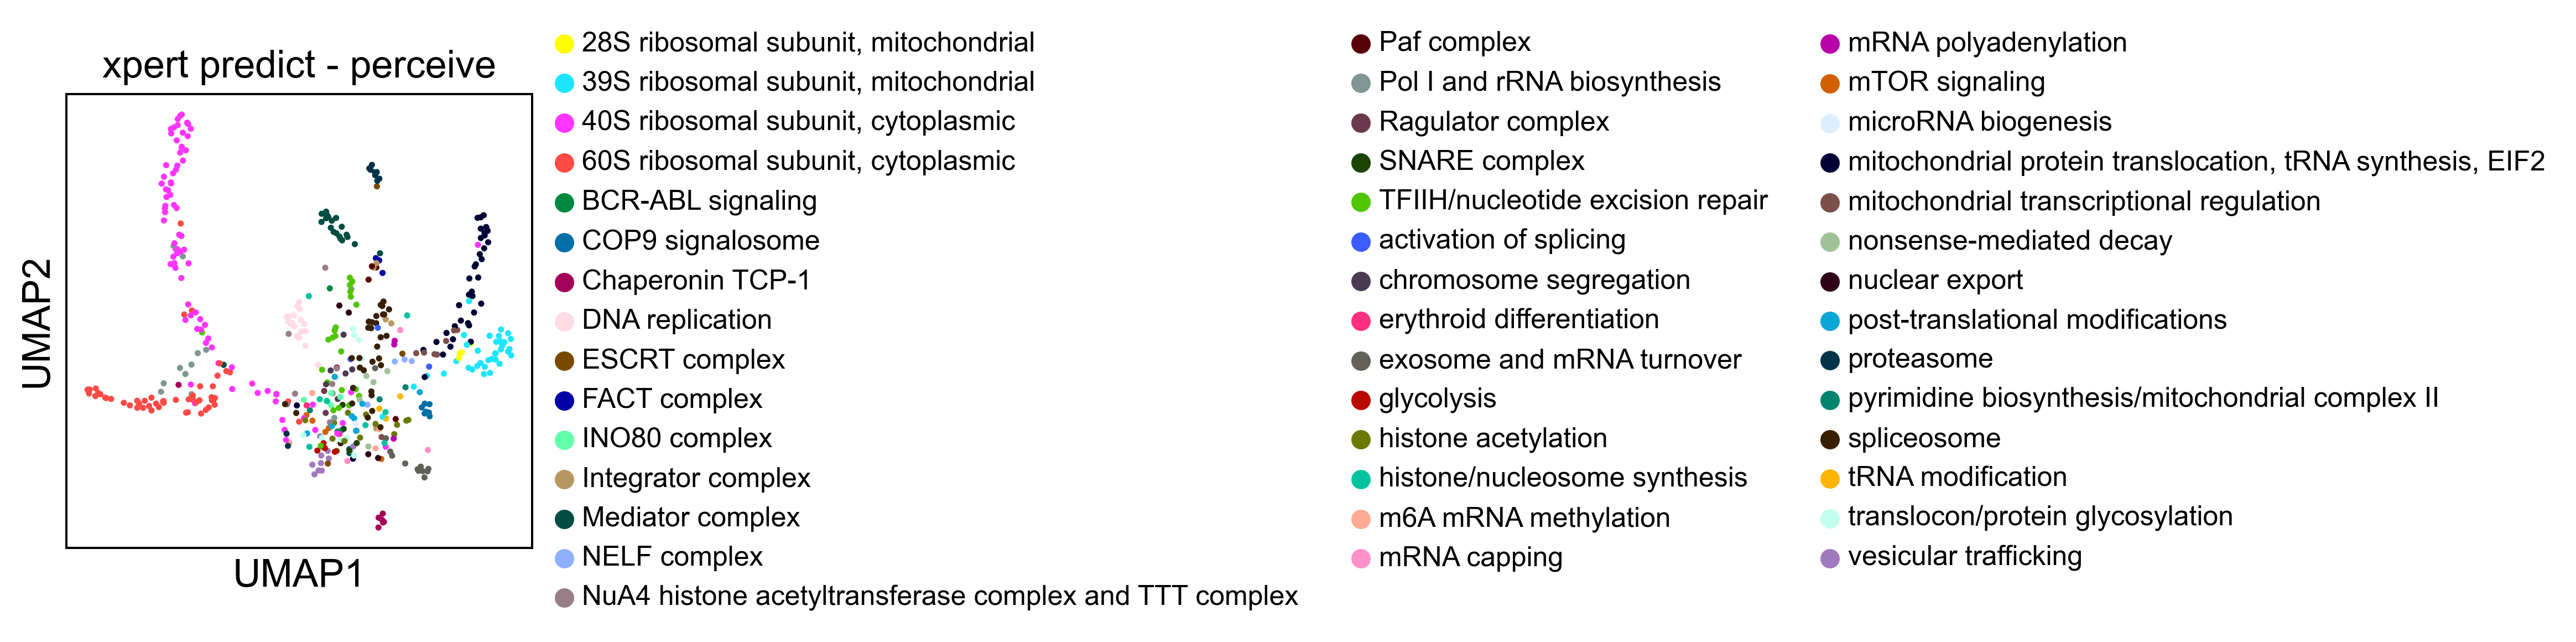

Classification Accuracy (mean): 0.593
Classification Accuracy (std): 0.021


In [26]:
import anndata as ad
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import scanpy as sc

name_list = ['perceive']
for i, _xpert_embed in enumerate([
    xpert_embed, 
    ]):

    adata_sub = ad.AnnData(X=_xpert_embed,
                        obs = pd.DataFrame(index=label_genes))

    common_labels = [str(gene_to_pathway[pert]) if pert in gene_to_pathway else 'unknown' for pert in adata_sub.obs_names]
    adata_sub.obs['pathway'] = common_labels

    # - process data to plot umap
    min_mean       =0.0125
    max_mean       =3
    min_disp       =0.5
    n_neighbors    =10
    n_pcs          =30
    scale_mode = False


    # sc.pp.filter_cells(adata_sub, min_genes=200)
    # sc.pp.filter_genes(adata_sub, min_cells=3)

    # sc.pp.normalize_per_cell(adata_sub, key_n_counts='n_counts_all')
    # sc.pp.log1p(adata_sub)
    # sc.pp.highly_variable_genes(adata_sub, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
    # sc.pp.highly_variable_genes(adata_sub, n_top_genes=2000)

    adata_sub.raw = adata_sub
    # adata_sub = adata_sub[:, adata_sub.var.highly_variable]
    if scale_mode:
        sc.pp.scale(adata_sub)
    # pca
    sc.tl.pca(adata_sub, svd_solver='arpack',random_state=2022)
    # neighbors
    sc.pp.neighbors(adata_sub, n_neighbors=n_neighbors, n_pcs=n_pcs,random_state=2022)
    # check umap
    sc.tl.umap(adata_sub,random_state=2022)

    point_size = 20
    sc.settings.set_figure_params(dpi=180, facecolor='white')
    plt.rcParams["figure.figsize"] = [3, 3]
    sc.pl.umap(adata_sub, 
            color=[
                'pathway',
                            ],size=point_size,legend_fontsize=10,
            # color_map='magma',
            ncols=1, wspace=0.4,legend_loc='right margin',
            cmap='coolwarm',
            title = f'xpert predict - {name_list[i]}',
            )

    X_umap = adata_sub.obsm['X_umap']

    # 使用 KNN 分类器
    knn = KNeighborsClassifier(n_neighbors=5)
    scores = cross_val_score(knn, X_umap, common_labels, cv=5)

    print(f"Classification Accuracy (mean): {scores.mean():.3f}")
    print(f"Classification Accuracy (std): {scores.std():.3f}") 